# Load the data

In [ ]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

# Show time series for all chemostats of simulation no. X

In [ ]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

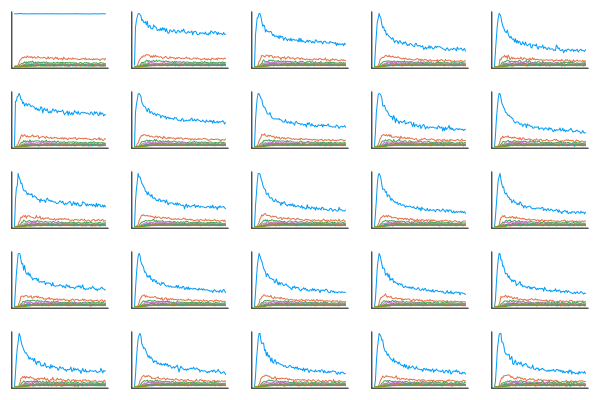

In [4]:
using DataFrames, Plots, FileIO

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        # plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none, xlabel="", ylabel="", xticks=false, yticks=false)
    end
end

display(plot_grid)
# savefig(plot_grid, "./plots/ts-gridplot.pdf")

# Get the final populations

In [20]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 25
nspecies = 10
t = 100

ts_array = []

for i in 1:nsims
    sim = sim_array[i]
    df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
    df = filter(row -> row[:time] == t, df)
    df.variable = parse.(Int, df.variable) # convert variable to ints
    push!(ts_array, df)
end

# Dimensionality reduction (time, chemostats)

In [ ]:
# drop the time
for i in 1:nsims
    df = ts_array[i]
    df_new = select(df, Not(:time))
    ts_array[i] = df_new
end

In [ ]:
# drop the chemostats (by combining the frequencies of each integer across all of them)
for i in 1:nsims
    df = ts_array[i]
    result = combine(groupby(df, :variable), :value => sum)
    ts_array[i] = result
end

# Calculate the abundance

In [83]:
for i in 1:nsims
    df = ts_array[i]
    total_value = sum(df.value_sum)
    df.abundance = df.value_sum ./ total_value
    ts_array[i] = df
end

# Determine the maximum complexity of molecules above some abundance threshold

In [86]:
function find_highest_molecule(df, threshold)
    # Define the threshold
    X = threshold

    # Filter the DataFrame to get rows where abundance is greater than X
    filtered_df = filter(row -> row.abundance > X, df)

    # Check if there are any rows that meet the condition
    if nrow(filtered_df) > 0
        # Find the row with the maximum "variable" value
        highest_molecule = maximum(filtered_df.variable)
    else
        highest_molecule = NaN
    end

    return highest_molecule
end

find_highest_molecule (generic function with 1 method)

In [203]:
threshold_arr = exp10.(LinRange(-5,-1,5))

n_thresholds = length(threshold_arr)
highest_molecules = fill(NaN, n_thresholds, nsims)

for i in 1:n_thresholds
    for j in 1:nsims
        threshold = threshold_arr[i]
        df = ts_array[j]
        highest_molecule = find_highest_molecule(df, threshold)
        highest_molecules[i, j] = highest_molecule
    end
end

In [204]:
# get the outflow_rates
kd_arr = zeros(nsims)

for i in 1:nsims
    kd_arr[i] = sim_array[i].all_constants[1,3]
end

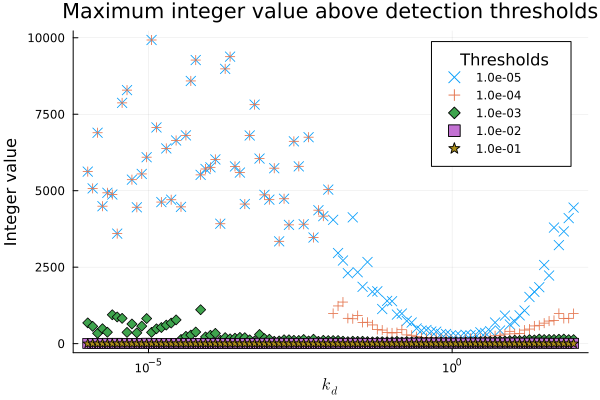

In [214]:
using Printf

s = scatter(title="Maximum integer value above detection thresholds",
            xlabel=L"k_d", ylabel="Integer value", xscale=:log10,
            legendtitle="Thresholds")

markers = [:x, :+, :diamond, :square, :star5, :x, :+]

for i in 1:n_thresholds
    label = @sprintf("%.1e", threshold_arr[i])
    scatter!(s, kd_arr, highest_molecules[i,:], marker = (markers[i], 5), alpha=1.0, label=label)
end

display(s)



# Plot the mass against the diffusion coefficient

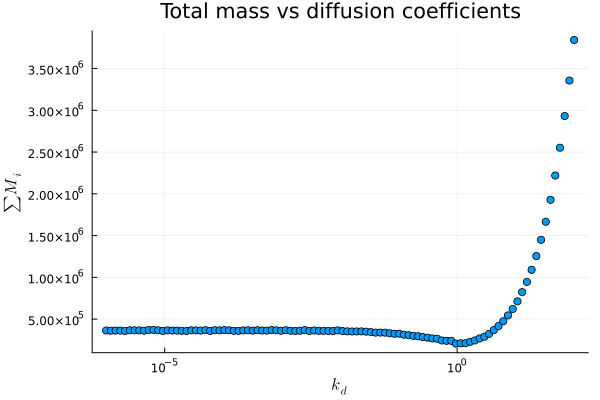

In [224]:
using LaTeXStrings

kd_arr = exp10.(LinRange(-6,2,nsims))

s = scatter(xlabel=L"k_d", ylabel=L"\sum M_i", title="Total mass vs diffusion coefficients", legend=:none,
            xscale=:log10)
scatter!(s, kd_arr, total_mass)

display(s)